In [38]:
import numpy as np

from nastran.aero.analysis.flutter import FlutterSubcase
from nastran.structures.panel import IsotropicPlate
from nastran.structures.material import IsotropicMaterial
from nastran.aero.superpanels import SuperAeroPanel5
from nastran.aero.analysis.panel_flutter import PanelFlutterPistonAnalysisModel, PanelFlutterSubcase
from nastran.thermo.analysis.steady_state import SteadyStateThermoAnalysisModel, ThermoSubcase


In [39]:
## Setup structural model
a, b = 300., 300
p1 = np.array([0, 0, 0])
p2 = p1 + np.array([a, 0, 0])
p3 = p1 + np.array([a, b, 0])
p4 = p1 + np.array([0, b, 0])

nchord, nspan = 20, 20

In [40]:
al = IsotropicMaterial(1, 71700., .33, 26900., 2.81e-9, alpha=21e-6)
al.to_mat1()

MAT1           1  71700.  26900.     .33  2.81-9 .000021

In [41]:
plate = IsotropicPlate.create_plate(p1, p2, p3, p4, nspan, nchord, 1, 1.5, al)
print(plate.bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.nodes
  GRID     : 441

bdf.elements
  CQUAD4   : 400

bdf.properties
  PSHELL   : ???

bdf.materials
  MAT1     : 1




In [42]:
# %%

params = {
    'LGDISP': 1,
    'NLTOL': 0,
}

thermal = SteadyStateThermoAnalysisModel(plate.bdf, params=params)

thermal.init_temp = 0.00001
thermal.max_temp = 420
step = 50.
thermal.ni = round((thermal.max_temp-thermal.init_temp)/step)

spanel_p = SuperAeroPanel5(1, p1, p2, p3, p4, nchord, nspan, theory='VANDYKE')
thermal.write_cord2r_cards(spanel_p)

thermal.write_cards()


from nastran.structures.bc import create_spcs_and_subcases, generate_bc_case, create_springs


spc_cases = {
    # 1: generate_bc_case('SSSS'),
    1: generate_bc_case('SSSS')
}

nodes = plate.limit_nodes()
nodes[2] = nodes[2][1:-1]
nodes[3] = nodes[3][1:-1]

create_spcs_and_subcases(thermal, spc_cases, nodes, PanelFlutterSubcase)
# create_springs(thermal, plate.limit_nodes())

# spc_id = thermal.idutil.get_next_sid()
# for comp, nds in zip(['123']*4, plate.limit_nodes()):
    # if comp == '':
        # continue
    # thermal.model.add_spc1(spc_id, comp, nds)
# thermal.model.case_control_deck.add_parameter_to_global_subcase('SPC = %d' % spc_id)


#%%
thermal_filename = 'metallic-thermic'
thermal.model.write_bdf('test/'+thermal_filename+'.bdf', enddata=True)




subcase=1 already exists...skipping


In [43]:

# %%

config = {
    'vref': 1000.,                      # used to calculate the non-dimensional dynamic pressure must be the same in control case (mm/s in the case)
    'ref_rho': 1.225e-12,               # air density reference (ton/mm^3 in the case)
    'ref_chord': 300.,                  # reference chord (mm in the case)
    'n_modes': 15,                      # number searched modes in modal analysis
    'frequency_limits': 
        [.0, 1000.],                    # the range of frequency (Hz) in modal analysis
    'method': 'PK',                     # the method for solving flutter (it will determine the next parameters
    'densities_ratio': [.5],            # rho/rho_ref -> 1/2 simulates the "one side flow" of the panel (? reference ?)
    'machs': [3.0],      # Mach numbers
    'alphas': [0., 0., 0., 0.],         # AoA (°) -> 0 is more conservative (? reference ?)
    'reduced_frequencies': 
        [.001, .1, .2, .4],    # reduced frequencies (k) (check influence)
    'velocities':                       # velocities (mm/s in the case)
        np.linspace(822, 1066, 50)*1000,
}

params =  {
    'VREF': 1000.0,
    'COUPMASS': 1,
    'LMODES': 15,
    'WTMASS': 1.,
    'GRDPNT': 1,
    'OPPHIPA': 1,
    # 'POST': [-1]
}

analysis = PanelFlutterPistonAnalysisModel(params=params)
analysis.set_global_case_from_dict(config)


# %%

spanel_p = SuperAeroPanel5(1, p1, p2, p3, p4, nchord, nspan, theory='VANDYKE')
analysis.add_superpanel(spanel_p)

analysis.write_cards()

#%%

temp_cases = np.linspace(thermal.init_temp, thermal.max_temp, thermal.ni)
temp_names = []

for i, temp in enumerate(temp_cases):
    sub_config = {
        'LABEL': 'TEMP LOAD %f' % temp,
    }

    analysis.model.case_control_deck.create_new_subcase(1)
    analysis.model.case_control_deck.add_parameter_to_local_subcase(1, 'PARAM, NMLOOP, %d' % (i+1))
    analysis.model.case_control_deck.add_parameter_to_local_subcase(1, 'LABEL =  TEMP LOAD %f' % temp)
    analysis.model.case_control_deck.add_parameter_to_local_subcase(1, 'SPC =  %d' % 1)

    restart_filename = 'thermal-restart-'+str(i+1)
    temp_names.append(restart_filename)
    analysis.model.write_bdf('test/'+restart_filename+'.bdf', enddata=True)

    with open('test/'+restart_filename+'.bdf', 'r') as f:
        lines = f.readlines()

    lines.insert(0, "ASSIGN MASTER='.\\"+ thermal_filename +".MASTER'\n")
    lines.insert(1,'RESTART VERSION=1,KEEP\n')

    with open('test/'+restart_filename+'.bdf', 'w') as f:
        f.writelines(lines)

Aerodynamic Flutter solution created!


subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping


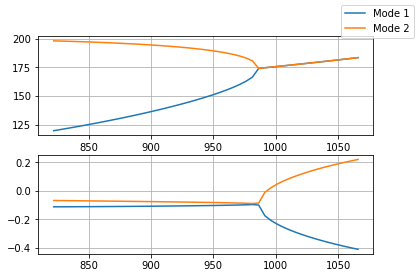

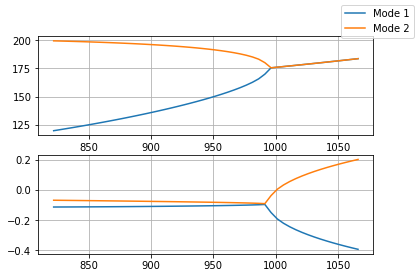

In [56]:

# %%
# %%

from nastran.aero.post import read_f06, get_critical_roots, plot_vf_vg

#%%
restart_filename = 'thermal-restart-8'
df = read_f06('test/'+restart_filename+'.r.f06')
# df.xs((6., 4), level=('POINT', 'INDEX'))
# p = plot_vf_vg(df)
lst = [False]*len(df)
idx = [1, 2]
for i in idx:
    lst = lst | (df.index.get_level_values(2) == i)
p = plot_vf_vg(df.loc[lst])

restart_filename = 'thermal-restart-1'
df = read_f06('test/'+restart_filename+'.r.f06')
# df.xs((6., 4), level=('POINT', 'INDEX'))
# p = plot_vf_vg(df)
lst = [False]*len(df)
idx = [1, 2]
for i in idx:
    lst = lst | (df.index.get_level_values(2) == i)
p = plot_vf_vg(df.loc[lst])


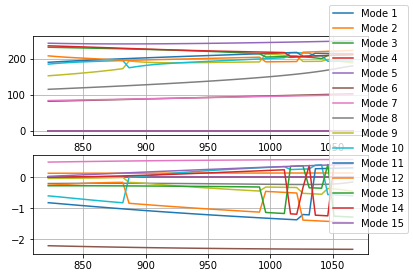

In [37]:

# %%
# %%

from nastran.aero.post import read_f06, get_critical_roots, plot_vf_vg

#%%
restart_filename = 'thermal-restart-2'
df = read_f06('test/'+restart_filename+'.f06')
# df.xs((6., 4), level=('POINT', 'INDEX'))
p = plot_vf_vg(df)


In [ ]:
#%%
from nastran.aero.post import read_and_concat_f06s
df = read_and_concat_f06s(
    list(map(lambda a: 'test/'+a+'.f06', temp_names)), temp_cases, 'TEMP')

#%%
df = df.loc[df.FREQUENCY > 0.0]
df = df.loc[df.KFREQ > 0.0]
#%%
critic_df = get_critical_roots(df, -1e-3)


# %%
i = 0
p = plot_vf_vg(df.xs((df.index.levels[0][i]), level=('TEMP')))
p.title = df.index.levels[0][i]
p
# %%